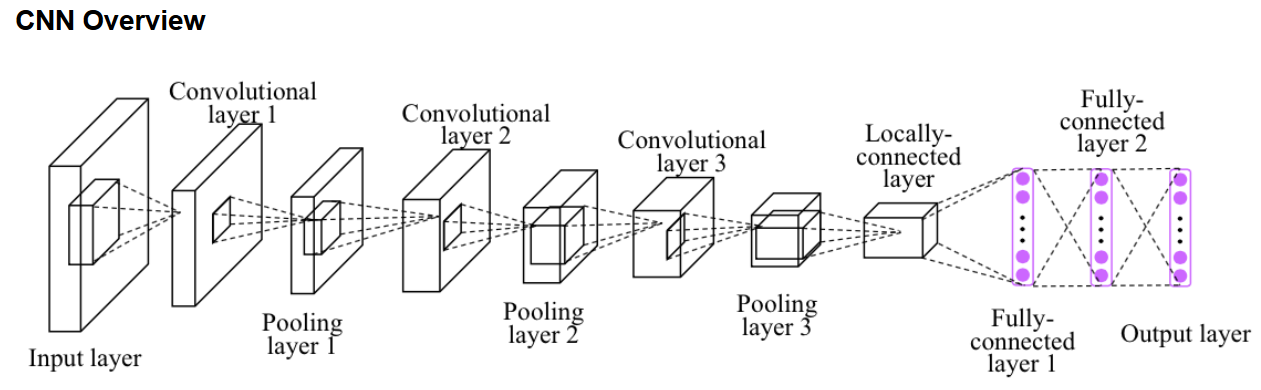

In [3]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST-data", one_hot=True)

Extracting ../MNIST-data/train-images-idx3-ubyte.gz
Extracting ../MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST-data/t10k-labels-idx1-ubyte.gz


In [4]:
# Training Parameters
learning_rate = 0.001
num_steps = 300
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    # strides其为长度为4的一阶张量
    # 并且要求strides[0] = strides[3] = 1
    # strides[1]，strides[2]决定卷积核在输入图像in_hight，in_width方向的滑动步长
    x = tf.nn.conv2d(x,
                     W,
                     strides=[1, strides, strides, 1],
                     padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x,
                          ksize=[1, k, k, 1],
                          strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    # Dropout就是在不同的训练过程中随机扔掉一部分神经元。
    # 也就是让某个神经元的激活值以一定的概率p，让其停止工作
    # 这次训练过程中不更新权值，也不参加神经网络的计算。
    # 但是它的权重得保留下来（只是暂时不更新而已），因为下次样本输入时它可能又得工作了
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [6]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                 labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps + 1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0}))

Step 1, Minibatch Loss= 54235.9883, Training Accuracy= 0.078
Step 10, Minibatch Loss= 16831.8027, Training Accuracy= 0.305
Step 20, Minibatch Loss= 8978.3076, Training Accuracy= 0.547
Step 30, Minibatch Loss= 5812.1240, Training Accuracy= 0.641
Step 40, Minibatch Loss= 2058.8887, Training Accuracy= 0.844
Step 50, Minibatch Loss= 4166.8149, Training Accuracy= 0.773
Step 60, Minibatch Loss= 3697.4316, Training Accuracy= 0.836
Step 70, Minibatch Loss= 2577.9341, Training Accuracy= 0.859
Step 80, Minibatch Loss= 2618.5603, Training Accuracy= 0.852
Step 90, Minibatch Loss= 1216.4507, Training Accuracy= 0.930
Step 100, Minibatch Loss= 3309.8745, Training Accuracy= 0.859
Step 110, Minibatch Loss= 1630.4630, Training Accuracy= 0.898
Step 120, Minibatch Loss= 1834.0388, Training Accuracy= 0.922
Step 130, Minibatch Loss= 853.2021, Training Accuracy= 0.938
Step 140, Minibatch Loss= 2289.5137, Training Accuracy= 0.891
Step 150, Minibatch Loss= 1378.4738, Training Accuracy= 0.883
Step 160, Minibatc